# Import Library

In [1]:
from rdkit import Chem
import math
import pandas as pd
import pickle
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import numpy as np
from torch_geometric.nn import GINConv, GINEConv, GCNConv, GraphConv, SAGEConv, DenseSAGEConv, DenseGraphConv, ChebConv, dense_mincut_pool, global_add_pool, global_mean_pool
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils import generate_graph

# Run Pytorch on CUDA

In [2]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# DataSet & DataLoader

## Create Custom Data Class

In [3]:
class MOFData(Data):
    def __init__(self, mof_node = None, mof_edge_index = None, mof_edge_attr = None,
                        metal_node = None, metal_edge_index = None, metal_edge_attr = None,
                        organ1_node = None, organ1_edge_index = None, organ1_edge_attr = None,
                        organ2_node = None, organ2_edge_index = None, organ2_edge_attr = None,
                        mofname = None, x_feat = None, y = None):
        super().__init__()
        self.mof_node = mof_node
        self.mof_edge_index = mof_edge_index
        self.mof_edge_attr = mof_edge_attr
        
        self.metal_node = metal_node
        self.metal_edge_index = metal_edge_index
        self.metal_edge_attr = metal_edge_attr
        
        self.organ1_node = organ1_node
        self.organ1_edge_index = organ1_edge_index
        self.organ1_edge_attr = organ1_edge_attr
        
        self.organ2_node = organ2_node
        self.organ2_edge_index = organ2_edge_index
        self.organ2_edge_attr = organ2_edge_attr
        
        self.mofname = mofname
        self.x_feat = x_feat
        self.y = y
        
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'mof_edge_index':
            return self.mof_node.size(0)
        if key == 'metal_edge_index':
            return self.metal_node.size(0)
        if key == 'organ1_edge_index':
            return self.organ1_node.size(0)
        if key == 'organ2_edge_index':
            return self.organ2_node.size(0)
        else:
            return super().__inc__(key, value, *args, **kwargs)

## Generate Data

In [65]:
df = pd.read_csv('data/test/clean_test_linker.csv')
smiles = pd.read_csv('data/test/smiles_test.csv')
data = df.join(smiles.set_index('MOFname'), on='MOFname')

data = data.dropna(subset=['Smiles'])
data = data.reset_index(drop=True)
# data = data.drop('Unnamed: 0', axis=1)
print(data.isnull().sum())
print(data.shape)

MOFname                                          0
topo_0                                           0
topo_1                                           0
topo_2                                           0
topo_3                                           0
topo_4                                           0
topo_5                                           0
topo_6                                           0
topo_7                                           0
topo_8                                           0
topo_9                                           0
volume [A^3]                                     0
weight [u]                                       0
density [g/cm^3]                                 0
surface_area [m^2/g]                             0
void_fraction                                    0
void_volume [cm^3/g]                             0
functional_groups                                0
metal_linker                                     0
organic_linker1                

In [67]:
data_list = []
data_dict = []
drop_feat = ['MOFname', 'weight [u]', 'functional_groups', 'Smiles', 'metal_linker', 'organic_linker1', 'organic_linker2'] #, 'CO2_working_capacity [mL/g]'
c = 1
for _, line in data.iterrows():
    mof = Chem.MolFromSmiles(line['Smiles'])
    metal = Chem.MolFromSmiles(line['metal_linker'])
    organ1 = Chem.MolFromSmiles(line['organic_linker1'])
    organ2 = Chem.MolFromSmiles(line['organic_linker2'])
    
    if mof == None or metal == None or organ1 == None or organ2 == None:  #or metal == None or organ1 == None or organ2 == None
        continue
    
    mof_node, mof_edge_index, mof_edge_attr = generate_graph(mof)
    metal_node, metal_edge_index, metal_edge_attr = generate_graph(metal)
    organ1_node, organ1_edge_index, organ1_edge_attr = generate_graph(organ1)
    organ2_node, organ2_edge_index, organ2_edge_attr = generate_graph(organ2)


    x_feat = line.drop(drop_feat).values.astype(float)
    x_feat = np.expand_dims(x_feat, axis=0)
    x_feat = torch.tensor(x_feat)
#     y=torch.tensor([line['CO2_working_capacity [mL/g]']], dtype=torch.float).view(1, -1)
    
    data_d = MOFData(mof_node = mof_node, mof_edge_index = mof_edge_index, mof_edge_attr = mof_edge_attr,
                  metal_node = metal_node, metal_edge_index = metal_edge_index, metal_edge_attr = metal_edge_attr,
                  organ1_node = organ1_node, organ1_edge_index = organ1_edge_index, organ1_edge_attr = organ1_edge_attr,
                  organ2_node = organ2_node, organ2_edge_index = organ2_edge_index, organ2_edge_attr = organ2_edge_attr,
                  mofname=line['MOFname'], x_feat=x_feat) #, y=y
#     data_d.mof_num_nodes = len(mof.GetAtoms())
    data_list.append(data_d)
    data_dict.append(line['MOFname'])
    
    if(c%10000==0):
        print('done:',c)
    c=c+1

done: 10000


## Load Data

In [34]:
data_list = pickle.load(open('data/train/graph_concat_linker_replace_surface.pkl', 'rb'))

In [35]:
import random
random.seed(10)

datasets = data_list

train_dataset, test_dataset = train_test_split(datasets, test_size=0.16, random_state = 1, shuffle=True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 55120
Number of test graphs: 10500


In [36]:
train_feat = []
test_feat = []

for train_data in train_dataset:
    train_feat.append(train_data.x_feat)
    
for test_data in test_dataset:
    test_feat.append(test_data.x_feat)


train_feat = torch.cat(train_feat, axis=0)
test_feat = torch.cat(test_feat, axis=0)

sc = StandardScaler()
train_feat = torch.from_numpy(sc.fit_transform(train_feat))
test_feat = torch.from_numpy(sc.transform(test_feat))

for i, data in enumerate(train_dataset):
    data.x_feat = train_feat[i].unsqueeze(0)

for i, data in enumerate(test_dataset):
    data.x_feat = test_feat[i].unsqueeze(0)

In [37]:
from torch_geometric.loader import DataLoader
import numpy as np

train_loader = DataLoader(train_dataset, batch_size=128, follow_batch=['mof_node', 'metal_node', 'organ1_node', 'organ2_node'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, follow_batch=['mof_node', 'metal_node', 'organ1_node', 'organ2_node'], shuffle=False)

# Model

## GINE Model

In [8]:
class GINE(torch.nn.Module):
    def __init__(self, in_channels, in_attr, dim, out_channels):
        super(GINE, self).__init__()

        self.attr1 = Sequential(Linear(in_attr, in_channels), BatchNorm1d(in_channels), ReLU())
        self.conv1 = GINEConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr2 = Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU())
        self.conv2 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr3 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv3 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr4 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv4 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr5 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv5 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.lin1 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.lin2 = Linear(dim, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        edge_attr = self.attr1(edge_attr)
        x = self.conv1(x, edge_index, edge_attr)
        
        edge_attr = self.attr2(edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        
        edge_attr = self.attr3(edge_attr)
        x = self.conv3(x, edge_index, edge_attr)
        
        edge_attr = self.attr4(edge_attr)
        x = self.conv4(x, edge_index, edge_attr)
        
        edge_attr = self.attr5(edge_attr)
        x = self.conv5(x, edge_index, edge_attr)
        
        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [9]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(GIN, self).__init__()

        self.conv1 = GINConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv3 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv4 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv5 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, out_channels)
        self.lin3 = Linear(out_channels, out_channels)



    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        x = self.conv5(x, edge_index)
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(in_channels, dim)
        self.conv2 = GCNConv(dim, dim)
        self.conv3 = GCNConv(dim, dim)
        self.conv4 = GCNConv(dim, dim)
        self.lin = Linear(dim, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = self.lin(x).relu()
        return x

In [44]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels, num_of_centers=20):
        super(SAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, dim)
        self.conv2 = SAGEConv(dim, dim)
        self.conv3 = SAGEConv(dim, dim)
        self.pool1 = Linear(dim, num_of_centers)
        self.conv4 = DenseSAGEConv(dim, dim)
        self.lin = Linear(dim, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
#         x = self.conv3(x, edge_index).relu()
        
        x, mask = to_dense_batch(x, batch) 
        adj = to_dense_adj(edge_index, batch)
        s = self.pool1(x)
        
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask)
        
        x = self.conv4(x, adj).relu()
        x = x.mean(dim=1)
        x = self.lin(x).relu()
        return x, mincut_loss, ortho_loss

In [45]:
class Graph(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels, num_of_centers=20):
        super(Graph, self).__init__()
        self.conv1 = GraphConv(in_channels, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.pool1 = Linear(dim, num_of_centers)
        self.conv4 = DenseGraphConv(dim, dim)
        self.lin = Linear(dim, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
#         x = self.conv3(x, edge_index).relu()
        
        x, mask = to_dense_batch(x, batch) 
        adj = to_dense_adj(edge_index, batch)
        s = self.pool1(x)
        
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask)
        
        x = self.conv4(x, adj).relu()
        x = x.mean(dim=1)
        x = self.lin(x).relu()
        return x, mincut_loss, ortho_loss

## MLP Model

In [46]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(MLP, self).__init__()

        self.lin1 = Linear(in_channels, dim)
        self.lin2 = Linear(dim, dim)
        self.lin3 = Linear(dim, dim)
        self.lin4 = Linear(dim, out_channels)

    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x).relu()
#         x = self.lin3(x).relu()
        x = self.lin4(x).relu()
        return x

## Cross Network

In [47]:
class CrossNet(nn.Module):

    def __init__(self, in_features, layer_num=2):
        super(CrossNet, self).__init__()
        self.layer_num = layer_num
        self.kernels = nn.Parameter(torch.Tensor(self.layer_num, in_features, 1))
        self.bias = nn.Parameter(torch.Tensor(self.layer_num, in_features, 1))

        for i in range(self.kernels.shape[0]):
            nn.init.xavier_normal_(self.kernels[i])
        for i in range(self.bias.shape[0]):
            nn.init.zeros_(self.bias[i])

        self.to(device)

    def forward(self, inputs):
        x_0 = inputs.unsqueeze(2)
        x_l = x_0
        for i in range(self.layer_num):
            xl_w = torch.tensordot(x_l, self.kernels[i], dims=([1], [0]))
            dot_ = torch.matmul(x_0, xl_w)
            x_l = dot_ + self.bias[i] + x_l
        x_l = torch.squeeze(x_l, dim=2)
        return x_l

## Multi Input Model

In [48]:
class Net(torch.nn.Module):
    def __init__(self, in_mof, in_metal, in_organ1, in_organ2, in_xfeats, dim, out_channels):
        super(Net, self).__init__()

        self.mof_g = SAGE(in_mof, dim, 128) # SAGE
        self.metal_g = Graph(in_metal, dim, 128)
        self.organ1_g = Graph(in_organ1, dim, 128)
        self.organ2_g = Graph(in_organ2, dim, 128)
        self.mlp = MLP(in_xfeats, dim, 128)
        self.lin = Linear(256, 128)
        self.lin2 = Linear(128, 128)
        self.cross = CrossNet(128, layer_num=2)
        self.mlp_cross = MLP(128, 128, 128)
        self.mlp_out = MLP(256 + 128*3, 256, 256)
        self.out = Linear(256, out_channels)

    def forward(self, mof_node, mof_edge_index, mof_node_batch, 
                      metal_node, metal_edge_index, metal_node_batch,
                      organ1_node, organ1_edge_index, organ1_node_batch,
                      organ2_node, organ2_edge_index, organ2_node_batch, x_feat):
        
        mof, mof_mincut_loss, mof_ortho_loss = self.mof_g(mof_node, mof_edge_index, mof_node_batch)
        metal, metal_mincut_loss, metal_ortho_loss = self.metal_g(metal_node, metal_edge_index, metal_node_batch)
        organ1, organ1_mincut_loss, organ1_ortho_loss = self.organ1_g(organ1_node, organ1_edge_index, organ1_node_batch)
        organ2, organ2_mincut_loss, organ2_ortho_loss = self.organ2_g(organ2_node, organ2_edge_index, organ2_node_batch)
        x_feat = self.mlp(x_feat)
        
        concat = torch.cat((mof, x_feat), dim=1)
        x = self.lin(concat)
        x = F.dropout(x, p=0.3, training=self.training) # SAGE: 0.3
        x = self.lin2(x).relu()
        
        cross = self.cross(x)
        mlp_cross = self.mlp_cross(x)
        concat2 = torch.cat((cross, mlp_cross, metal, organ1, organ2), dim=1)
        
        x = self.mlp_out(concat2)
        x = F.dropout(x, p=0.3, training=self.training) # SAGE: 0.3
        out = self.out(x)
        return out, mof_mincut_loss + mof_ortho_loss + metal_mincut_loss + metal_ortho_loss + organ1_mincut_loss + organ1_ortho_loss + organ2_mincut_loss + organ2_ortho_loss

# Train

In [49]:
def train(train_loader):
    model.train()
    c=0
    correct=0
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out, pool_loss = model(data.mof_node, data.mof_edge_index, data.mof_node_batch,
                                data.metal_node, data.metal_edge_index, data.metal_node_batch,
                                data.organ1_node, data.organ1_edge_index, data.organ1_node_batch,
                                data.organ2_node, data.organ2_edge_index, data.organ2_node_batch, data.x_feat.float())  # Perform a single forward pass. , data.edge_attr.float()
    
        loss = criterion(out, data.y) + pool_loss  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        c=c+1
        correct+=loss.cpu().detach().numpy() - pool_loss.cpu().detach().numpy()
    return correct/c

def test(loader):
    model.eval()
    correct = 0
    c=0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out, pool_loss = model(data.mof_node, data.mof_edge_index, data.mof_node_batch,
                                data.metal_node, data.metal_edge_index, data.metal_node_batch,
                                data.organ1_node, data.organ1_edge_index, data.organ1_node_batch,
                                data.organ2_node, data.organ2_edge_index, data.organ2_node_batch, data.x_feat.float()) # , data.edge_attr.float()
    
        loss = criterion(out, data.y) + pool_loss  # Compute the loss.
        correct+=loss.cpu().detach().numpy() - pool_loss.cpu().detach().numpy()  # Check against ground-truth labels.
        c=c+1
    return correct / c  # Derive ratio of correct predictions.

In [50]:
num_mof_node = 9
num_metal_node = 9
num_organ1_node = 9
num_organ2_node = 9
hidden_channels = 32 # SAGE: 32
num_feats = 18
num_classes = 1
num_attr = 3

model = Net(num_mof_node, num_metal_node, num_organ1_node, num_organ2_node, num_feats, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.001
criterion = torch.nn.L1Loss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.85, patience=3, min_lr=0.000001) #factor=0.85

In [51]:
train_loss = []
test_loss = []
epochs = 200
print('start train')

for epoch in range(epochs):
    train_acc = train(train_loader)
    test_acc = test(test_loader)
    train_loss.append(train_acc)
    test_loss.append(test_acc)
    scheduler.step(test_acc)
    print(f'Epoch: {epoch+1:03d}, Train MAE: {train_acc:.4f}, Test MAE: {test_acc:.4f}')

start train
Epoch: 001, Train MAE: 37.4608, Test MAE: 26.2974
Epoch: 002, Train MAE: 26.1060, Test MAE: 23.2140
Epoch: 003, Train MAE: 24.2635, Test MAE: 23.3522
Epoch: 004, Train MAE: 23.2698, Test MAE: 23.6859
Epoch: 005, Train MAE: 22.9477, Test MAE: 21.3307
Epoch: 006, Train MAE: 22.8410, Test MAE: 21.1939
Epoch: 007, Train MAE: 22.1977, Test MAE: 21.6888
Epoch: 008, Train MAE: 22.2351, Test MAE: 20.8897
Epoch: 009, Train MAE: 22.3834, Test MAE: 20.6114
Epoch: 010, Train MAE: 22.4387, Test MAE: 22.1569
Epoch: 011, Train MAE: 22.0160, Test MAE: 20.6636
Epoch: 012, Train MAE: 21.8224, Test MAE: 21.7065
Epoch: 013, Train MAE: 21.7253, Test MAE: 20.1260
Epoch: 014, Train MAE: 21.6161, Test MAE: 19.9027
Epoch: 015, Train MAE: 21.1808, Test MAE: 20.4244
Epoch: 016, Train MAE: 21.2526, Test MAE: 22.8809
Epoch: 017, Train MAE: 21.4786, Test MAE: 19.9083
Epoch: 018, Train MAE: 20.9490, Test MAE: 20.0091
Epoch: 019, Train MAE: 20.8059, Test MAE: 20.5903
Epoch: 020, Train MAE: 20.8070, Test M

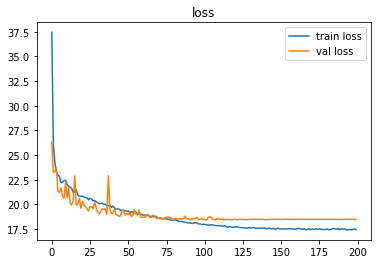

In [52]:
import matplotlib.pyplot as plt

plt.title('loss')
plt.plot(np.arange(epochs), train_loss, label='train loss')
plt.plot(np.arange(epochs), test_loss, label='val loss')

plt.legend()
plt.show()

In [21]:
save = False
if save:
    torch.save(model.state_dict(), "model/best_linkerGNNminCut.pt")

# Inference

## Preprocess Data

In [22]:
train_dataset = pickle.load(open('data/train/graph_concat_linker_replace_surface.pkl', 'rb'))
test_dataset = pickle.load(open('data/test/graph_concat_linker.pkl', 'rb'))

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 65620
Number of test graphs: 16235


In [23]:
train_feat = []
test_feat = []

for train_data in train_dataset:
    train_feat.append(train_data.x_feat)
    
for test_data in test_dataset:
    test_feat.append(test_data.x_feat)


train_feat = torch.cat(train_feat, axis=0)
test_feat = torch.cat(test_feat, axis=0)

sc = StandardScaler()
train_feat = torch.from_numpy(sc.fit_transform(train_feat))
test_feat = torch.from_numpy(sc.transform(test_feat))

for i, data in enumerate(train_dataset):
    data.x_feat = train_feat[i].unsqueeze(0)

for i, data in enumerate(test_dataset):
    data.x_feat = test_feat[i].unsqueeze(0)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=128, follow_batch=['mof_node', 'metal_node', 'organ1_node', 'organ2_node'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, follow_batch=['mof_node', 'metal_node', 'organ1_node', 'organ2_node'], shuffle=False)

## Load Model

In [132]:
num_mof_node = 9
num_metal_node = 9
num_organ1_node = 9
num_organ2_node = 9
hidden_channels = 32 # SAGE: 32
num_feats = 18
num_classes = 1
num_attr = 3

model = Net(num_mof_node, num_metal_node, num_organ1_node, num_organ2_node, num_feats, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.001
criterion = torch.nn.L1Loss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.85, patience=3, min_lr=0.000001) #factor=0.85

model.load_state_dict(torch.load('model/best_linkerGNNminCut.pt'))
model.eval()

Net(
  (mof_g): SAGE(
    (conv1): SAGEConv(9, 32)
    (conv2): SAGEConv(32, 32)
    (conv3): SAGEConv(32, 32)
    (conv4): SAGEConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (metal_g): Graph(
    (conv1): GraphConv(9, 32)
    (conv2): GraphConv(32, 32)
    (conv3): GraphConv(32, 32)
    (conv4): GraphConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (organ1_g): Graph(
    (conv1): GraphConv(9, 32)
    (conv2): GraphConv(32, 32)
    (conv3): GraphConv(32, 32)
    (conv4): GraphConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (organ2_g): Graph(
    (conv1): GraphConv(9, 32)
    (conv2): GraphConv(32, 32)
    (conv3): GraphConv(32, 32)
    (conv4): GraphConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (mlp): MLP(
    (lin1): Linear(in_features=18, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=32, bias=True)
    (lin3): Linear(i

## Evaluate Test

In [26]:
mofname = []
co2_select = []

for data in test_loader:  # Iterate in batches over the training dataset.
    data.to(device)
    
    out, pool_loss = model(data.mof_node, data.mof_edge_index, data.mof_node_batch,
                            data.metal_node, data.metal_edge_index, data.metal_node_batch,
                            data.organ1_node, data.organ1_edge_index, data.organ1_node_batch,
                            data.organ2_node, data.organ2_edge_index, data.organ2_node_batch, data.x_feat.float())
    
    mofname.append(data.mofname)
    co2_select.append(out.cpu().detach().numpy())
    
mofname = np.concatenate(mofname)
co2_select = np.concatenate(co2_select).flatten()

cut_mof_unit = lambda x: x.split('_')[-1]
id_ = np.array(list(map(cut_mof_unit, mofname)))

In [27]:
d = {'id': id_, 'CO2_working_capacity [mL/g]': co2_select}

df_inference = pd.DataFrame(d)

In [28]:
df_xgboost = pd.read_csv('xgboost_submission.csv')
df_xgboost = df_xgboost.set_index('id')

df_xgboost.loc[df_inference.id.values.astype(int)] = np.expand_dims(df_inference['CO2_working_capacity [mL/g]'].values, axis=1)
df_xgboost = df_xgboost.reset_index()

In [30]:
df_xgboost.to_csv('submission.csv', index=False)

In [29]:
df_xgboost

,id,CO2_working_capacity [mL/g]
0,68614,192.599228
1,68615,66.363136
2,68616,67.216171
3,68617,55.901829
4,68618,64.024391
...,...,...
16995,85609,-5.661958
16996,85610,1.520870
16997,85611,-0.013260
16998,85612,-0.944833


## Create Latent Space for AutoML

In [125]:
model.out=nn.Sequential(*list(model.out.children())[:-1])
model.eval()
model.to(device)

Net(
  (mof_g): SAGE(
    (conv1): SAGEConv(9, 32)
    (conv2): SAGEConv(32, 32)
    (conv3): SAGEConv(32, 32)
    (conv4): SAGEConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (metal_g): Graph(
    (conv1): GraphConv(9, 32)
    (conv2): GraphConv(32, 32)
    (conv3): GraphConv(32, 32)
    (conv4): GraphConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (organ1_g): Graph(
    (conv1): GraphConv(9, 32)
    (conv2): GraphConv(32, 32)
    (conv3): GraphConv(32, 32)
    (conv4): GraphConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (organ2_g): Graph(
    (conv1): GraphConv(9, 32)
    (conv2): GraphConv(32, 32)
    (conv3): GraphConv(32, 32)
    (conv4): GraphConv(32, 32)
    (lin): Linear(in_features=32, out_features=128, bias=True)
  )
  (mlp): MLP(
    (lin1): Linear(in_features=18, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=32, bias=True)
    (lin3): Linear(i

In [126]:
c=0
train_x = []
train_y = []
train_mofname = []

for data in train_loader:  # Iterate in batches over the training dataset.
    data.to(device)
    out = model(data.mof_node, data.mof_edge_index, data.mof_node_batch,
                data.metal_node, data.metal_edge_index, data.metal_node_batch,
                data.organ1_node, data.organ1_edge_index, data.organ1_node_batch,
                data.organ2_node, data.organ2_edge_index, data.organ2_node_batch, data.x_feat.float()).cpu().detach().numpy()
    x_feat = data.x_feat.cpu().detach().numpy()

    out = np.concatenate((out, x_feat), axis=1)
    train_x.append(out)
    train_y.append(data.y.cpu().detach().numpy())
    train_mofname.append(data.mofname)
    c=c+1
    if(c%100==0):
        print('done:',c)

train_x = np.concatenate(train_x, axis=0)
train_y = np.concatenate(train_y, axis=0)
train_mofname = np.concatenate(train_mofname, axis=0)

done: 100
done: 200
done: 300
done: 400
done: 500


In [127]:
c=0
test_x = []
test_mofname = []

for data in test_loader:  # Iterate in batches over the training dataset.
    data.to(device)
    out = model(data.mof_node, data.mof_edge_index, data.mof_node_batch,
                data.metal_node, data.metal_edge_index, data.metal_node_batch,
                data.organ1_node, data.organ1_edge_index, data.organ1_node_batch,
                data.organ2_node, data.organ2_edge_index, data.organ2_node_batch, data.x_feat.float()).cpu().detach().numpy()
    x_feat = data.x_feat.cpu().detach().numpy()

    out = np.concatenate((out, x_feat), axis=1)
    test_x.append(out)
    test_mofname.append(data.mofname)
    c=c+1
    if(c%100==0):
        print('done:',c)

test_x = np.concatenate(test_x, axis=0)
test_mofname = np.concatenate(test_mofname, axis=0)

C:\Users\User\anaconda3\envs\TMLCC_CUDA\lib\site-packages\torch_geometric\data\storage.py:249: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'organ2_edge_index', 'mof_edge_index', 'x_feat', 'metal_edge_index', 'organ1_edge_index', 'metal_edge_attr', 'organ2_node', 'mofname', 'organ2_edge_attr', 'organ1_node', 'organ1_edge_attr', 'metal_node', 'mof_edge_attr', 'mof_node'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


done: 100


In [128]:
train_df = pd.DataFrame(train_x)
test_df = pd.DataFrame(test_x)

train_df['target'] = train_y.flatten()
test_df['mofname'] = test_mofname.flatten()

In [131]:
train_df.to_csv('data/train/Latent_SAGEGNN_feat_linker_train.csv',index=False)
test_df.to_csv('data/test/auto_SAGEGNN_feat_linker_test.csv',index=False)